# Identify Object Positions in Images - YOLO vs VLM 

In [ ]:
# Import YOLO and load a pre-trained model
from ultralytics import YOLO



# Load the YOLOv8 pre-trained model --> Laden eines vortrainierten YOLO-Modells:
model = YOLO('yolov8n.pt')  # nano model for quick inference


# Get the class ID for the target object
target_object_name = "cup"  # Replace with your target object name --> In diesen Zeilen definierst du das zu erkennende Objekt 
                            # (z.B. eine "Tasse" bzw. "cup"). model.names enthält die Namen aller Klassen, die das Modell erkennen kann. 
                            # Der Code sucht in dieser Liste nach der ID der "Tasse" (oder des gewählten Objekts).
class_names = model.names
target_class_id = next((class_id for class_id, name in class_names.items() if name == target_object_name), None)


# Hier wird überprüft, ob das Zielobjekt in der Liste der erkennbaren Objekte vorhanden ist.
if target_class_id is not None:
    # Perform inference
    results = model('images/table_scene.jpeg', save = True)  # Replace with your image path 
                                                             # Das Modell führt die Objekt­erkennung auf dem Bild table_scene.jpeg durch. 
                                                             # Das Argument save=True speichert die annotierte Bildversion mit den erkannten Objekten.



    # Filter bounding boxes for the target object
    # Die resultierenden Detektionen werden nach den Bounding Boxes gefiltert, die das Zielobjekt (z.B. "Tasse") enthalten. 
    # Für jede erkannte Box wird die Position (in Form von [x1, y1, x2, y2] Koordinaten) extrahiert, falls die Klasse übereinstimmt.
    detections = results[0].boxes
    specific_boxes = [
        box.xyxy[0].tolist()
        for box in detections
        if int(box.cls[0]) == target_class_id
    ]

    # Am Ende gibt der Code die Positionen der Bounding Boxes für das gesuchte Objekt aus.
    print(f"Bounding boxes for '{target_object_name}': {specific_boxes}")
else:
    print(f"Object name '{target_object_name}' not found in the model's class names.")


image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 2 potted plants, 2 dining tables, 4 books, 3 vases, 115.0ms
Speed: 3.1ms preprocess, 115.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
Bounding boxes for 'cup': [[615.28662109375, 553.3635864257812, 845.9586181640625, 780.4920654296875]]


Zusammengefasst: Dieser Code dient der Erkennung eines bestimmten Objekts (z.B. einer Tasse) auf einem Bild. Nachdem das Modell geladen wurde, wird das Bild verarbeitet, und die Bounding Boxes für das gesuchte Objekt werden extrahiert und ausgegeben.








### Utils 


In [2]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))





Die Funktion `plot_bounding_boxes` zeichnet Rechtecke (Bounding Boxes) auf einem Bild und fügt Textbeschreibungen für erkannte Objekte hinzu.

### Was macht sie genau?
- Sie lädt ein Bild.
- Sie zeichnet Rechtecke um Objekte, basierend auf deren Positionen (die als Koordinaten in der Eingabe übergeben werden).
- Sie fügt Text (z.B. "Tasse", "Auto") an der Position der Bounding Box hinzu.
- Sie verwendet dabei verschiedene Farben für jedes Rechteck.
- Am Ende zeigt sie das bearbeitete Bild an.

Die Funktion `parse_list_boxes` extrahiert Bounding Box-Koordinaten aus einem Text, während `parse_list_boxes_with_label` den Text in ein JSON-Format umwandelt, um Koordinaten und Labels zu extrahieren.


---------

Task:
- Consider the picture table_scene, identify in the picture where the coffee cup is
- Draw the prediction box on top of the image.
- Compare the results when run by Yolo, and the 2 VLMs- visualise the boxes on
the pics

# VLM (1): OPEN-AI

In [4]:
from openai import OpenAI
import os
import base64


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

openAIclient = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
img = "images/table_scene.jpeg"


In [5]:
# basic call to gpt4 with prompt and image
# Initialisierung der OpenAI-API Anfrage:
completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Detect if there is a cup in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax]. Just output the list."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                    }
                },
            ],
        }
    ],
)


# Wrap the text to a specified width

response = str(completion.choices[0].message.content)



In [6]:
# vorherige methode aufrufen
# das Modell wird beauftragt, ein Bild zu analysieren und die Koordinaten einer Bounding Box für einen Becher im Bild zu liefern.
response

'[434, 510, 470, 550]'

(1024, 1024)


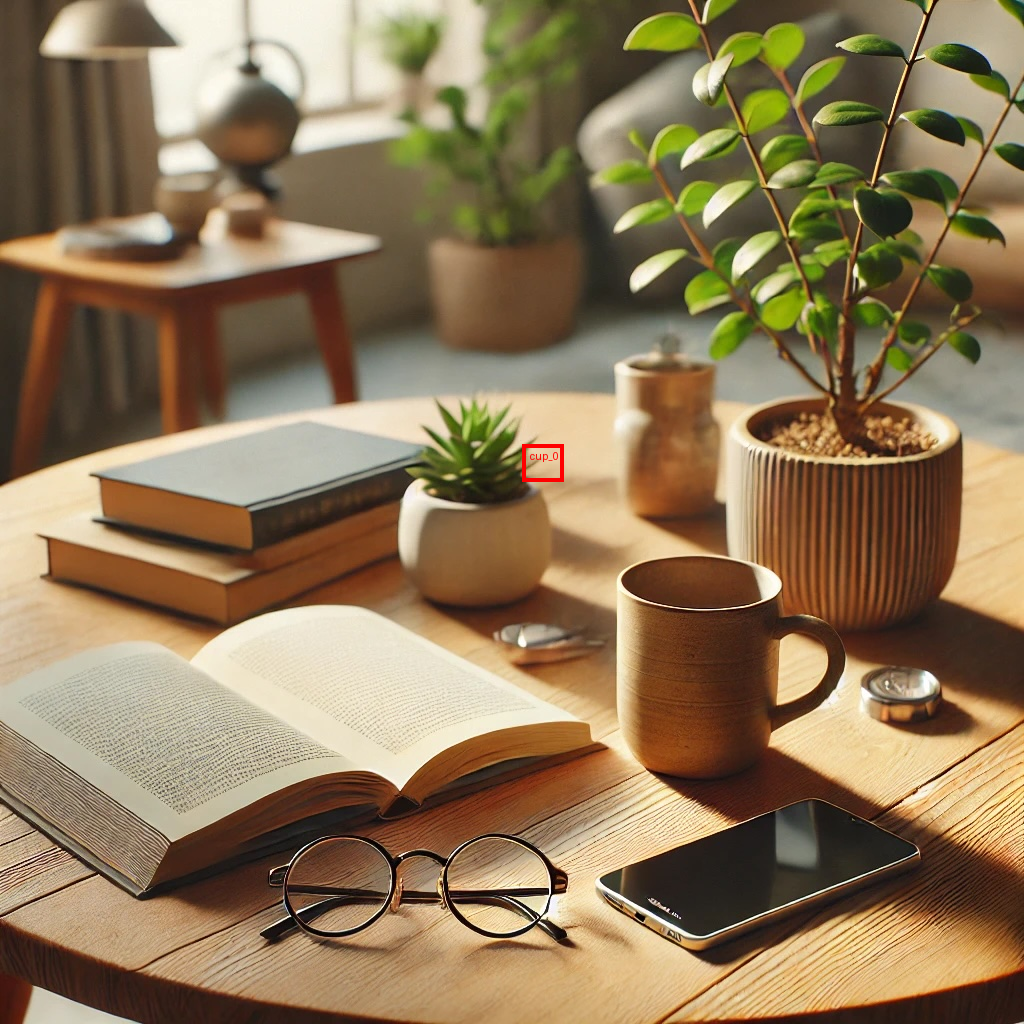

In [8]:
boxes= parse_list_boxes(response)
boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}
plot_bounding_boxes(Image.open(img), noun_phrases_and_positions=list(boxes.items()))

### Erklärung des Codes

1. **`parse_list_boxes(response)`**: Extrahiert die Koordinaten der Bounding Boxen aus der Antwort des Modells (z.B. `[100, 150, 200, 250]`).

2. **`boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}`**: Konvertiert die extrahierten Koordinaten in ein Dictionary, wobei jeder Eintrag eine einzigartige Bezeichner-ID (z.B. `cup_0`) erhält.

3. **`plot_bounding_boxes(...)`**: Zeichnet Bounding Boxen auf das Bild anhand der Koordinaten und zeigt das bearbeitete Bild an.

### Ablauf:
- Die Koordinaten für die Boxen werden aus der Modellantwort extrahiert.
- Ein Dictionary wird erstellt, um die Koordinaten mit eindeutigen IDs zu verbinden.
- Die Bounding Boxen werden auf dem Bild gezeichnet und angezeigt.


---------

 ---------

# VLM (2): GEMINI


In [9]:
%matplotlib inline
import os
import google.generativeai as genai
from PIL import Image
import requests
import io

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Erklärung des Codes (below)

1. **Bild öffnen**: Das Bild wird mit `Image.open(img)` geladen.

2. **API-Konfiguration**: Die Gemini API wird mit dem API-Schlüssel konfiguriert (`genai.configure(api_key=...)`).

3. **Modell auswählen**: Das Modell `gemini-1.5-pro` wird für die Analyse verwendet.

4. **Inhalt generieren**: Das Modell erhält das Bild und eine Textaufforderung, um die Koordinaten einer Tasse zu erkennen und im Format `[ymin, xmin, ymax, xmax]` zurückzugeben.

5. **Antwort**: Die Antwort wird mit `response.resolve()` verarbeitet und die Koordinaten werden mit `response.text` ausgegeben.

### Zusammenfassung:
Das Bild wird an Google Gemini geschickt, das Modell erkennt eine Tasse und gibt die Bounding-Box-Koordinaten als Liste zurück.


In [10]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a cup in the image and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[541, 596, 754, 818]


### Erklärung des Codes

1. **Koordinaten extrahieren**: Die `response.text` enthält die Koordinaten der Bounding Boxen (z.B. `[100, 150, 200, 250]`), die vom Modell zurückgegeben wurden.

2. **Koordinaten in Dictionary umwandeln**: 
   - Zuerst werden die Koordinaten der Bounding Boxen extrahiert.
   - Dann werden diese Koordinaten in ein Dictionary umgewandelt, wobei jeder Bounding Box eine eindeutige ID zugewiesen wird (z.B. `cup_0`, `cup_1`).

3. **Bounding Boxen visualisieren**: 
   - Schließlich werden die Bounding Boxen auf dem Bild angezeigt.

### Zusammenfassung:
- Die Koordinaten der Bounding Boxen werden aus der Antwort extrahiert, in ein Dictionary umgewandelt und dann auf dem Bild visualisiert.


(1024, 1024)


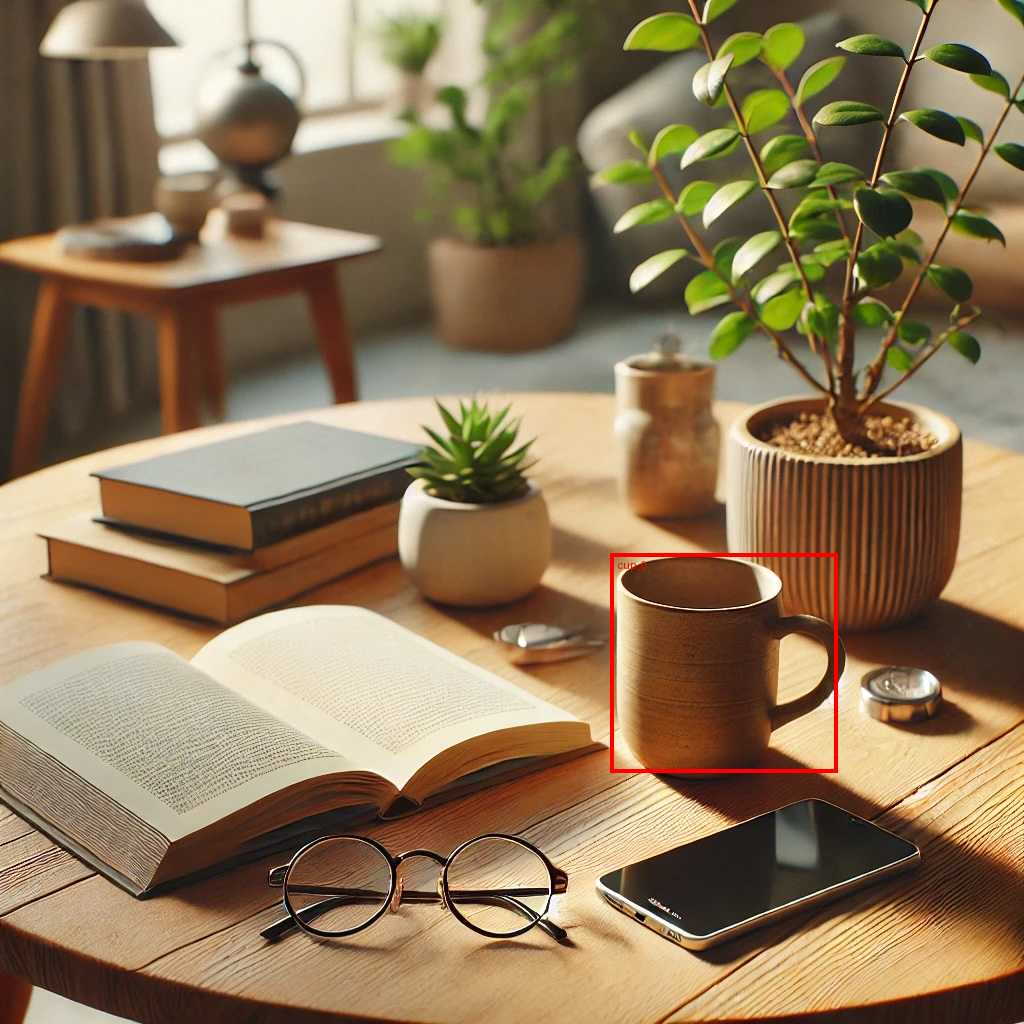

In [11]:
boxes= parse_list_boxes(response.text)
boxes = {f'cup_{i}': x for i, x in enumerate(boxes)}
plot_bounding_boxes(im, noun_phrases_and_positions=list(boxes.items()))